In [2]:
import json

with open('../mznc2025_probs/problems_with_descriptions.json', 'r') as f1:
    mznResults = json.load(f1)

with open('solver_benchmark_results.json', 'r') as f2:
    LLMResults = json.load(f2)


In [3]:
import pandas as pd

# Flatten problems_with_descriptions.json to a DataFrame
problems_df = pd.DataFrame.from_dict(mznResults, orient='index')
problems_df.index.name = 'problem_name'
# Keep only problem_name and top3_solvers columns
problems_df = problems_df[['top3_solvers']]


# Flatten solver_benchmark_results.json to a long DataFrame
records = []
for provider, models in LLMResults.items():
    for model, problems in models.items():
        for problem, solvers in problems.items():
            records.append({
                'provider': provider,
                'model': model,
                'problem': problem,
                'solvers': solvers
            })
results_df = pd.DataFrame(records)



problems_df.head(), results_df.head()

(                                      top3_solvers
 problem_name                                      
 atsp            [OR-Tools CP-SAT, COIN-BC, Gecode]
 black-hole      [Chuffed, OR-Tools CP-SAT, Gecode]
 carpet-cutting   [OR-Tools CP-SAT, Chuffed, HiGHS]
 cgt             [OR-Tools CP-SAT, Gecode, Chuffed]
 EchoSched        [OR-Tools CP-SAT, Chuffed, HiGHS],
   provider             model         problem  \
 0   gemini  gemini-2.5-flash            atsp   
 1   gemini  gemini-2.5-flash      black-hole   
 2   gemini  gemini-2.5-flash  carpet-cutting   
 3   gemini  gemini-2.5-flash             cgt   
 4   gemini  gemini-2.5-flash       EchoSched   
 
                               solvers  
 0  [OR-Tools CP-SAT, Gecode, Chuffed]  
 1  [Gecode, Chuffed, OR-Tools CP-SAT]  
 2  [Gecode, Chuffed, OR-Tools CP-SAT]  
 3  [Gecode, Chuffed, OR-Tools CP-SAT]  
 4  [OR-Tools CP-SAT, Chuffed, Gecode]  )

In [4]:
# NON TESTABLE MODELS: playai-tts, playai-tts-arabic, whisper-large-v3, deepseek-r1-distill-llama-70b, gemini-2.0-flash-lite, gemma2-9b-it, whisper-large-v3-turbo
# IGNORE DUE TO LIMITED REQUESTS: meta-llama/llama-prompt-guard-2-22m, meta-llama/llama-prompt-guard-2-86m
# VERY LIMITED: allam-2-7b
# We remove all the models above from results_df
exclude_models = {'playai-tts', 'playai-tts-arabic', 'whisper-large-v3', 'deepseek-r1-distill-llama-70b', 
                  'gemini-2.0-flash-lite', 'gemma2-9b-it', 'whisper-large-v3-turbo', 
                  'meta-llama/llama-prompt-guard-2-22m', 'meta-llama/llama-prompt-guard-2-86m',
                  'allam-2-7b'}
results_df = results_df[~results_df['model'].isin(exclude_models)]


## First Metric
For each model, we count for how many problems it guessed the first solver right

In [5]:
# For each model, count how many times the first guessed solver matches the top solver in problems_df

# Merge results_df with problems_df to get the ground truth top solver for each problem
results_with_gt = results_df.merge(problems_df, left_on='problem', right_index=True, how='left')

# Extract the top solver from the ground truth
results_with_gt['top_solver'] = results_with_gt['top3_solvers'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

# Extract the first guessed solver from the model's output (if not null/empty)
results_with_gt['first_guess'] = results_with_gt['solvers'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

# Compute correctness
results_with_gt['correct_first'] = results_with_gt['first_guess'] == results_with_gt['top_solver']

# Group by provider/model and count correct predictions
first_solver_accuracy = results_with_gt.groupby(['provider', 'model'])['correct_first'].sum().reset_index()
first_solver_accuracy = first_solver_accuracy.rename(columns={'correct_first': 'num_correct_first_solver'})

# Also count total attempted (non-null predictions) for normalization
first_solver_attempts = results_with_gt.groupby(['provider', 'model'])['first_guess'].count().reset_index()
first_solver_attempts = first_solver_attempts.rename(columns={'first_guess': 'num_attempted'})

# Merge counts
first_solver_accuracy = first_solver_accuracy.merge(first_solver_attempts, on=['provider', 'model'])

# Add accuracy as a percentage
first_solver_accuracy['accuracy_percent'] = 100 * first_solver_accuracy['num_correct_first_solver'] / first_solver_accuracy['num_attempted']

first_solver_accuracy.sort_values(['provider', 'accuracy_percent'], ascending=[True, False])

,provider,model,num_correct_first_solver,num_attempted,accuracy_percent
0,gemini,gemini-2.0-flash,13,20,65.000000
1,gemini,gemini-2.5-flash,13,20,65.000000
3,gemini,gemini-2.5-pro,12,20,60.000000
2,gemini,gemini-2.5-flash-lite,10,20,50.000000
15,groq,qwen/qwen3-32b,8,19,42.105263
14,groq,openai/gpt-oss-20b,7,20,35.000000
6,groq,llama-3.1-8b-instant,5,19,26.315789
8,groq,meta-llama/llama-4-maverick-17b-128e-instruct,5,19,26.315789
5,groq,groq/compound-mini,5,20,25.000000
9,groq,meta-llama/llama-4-scout-17b-16e-instruct,5,20,25.000000


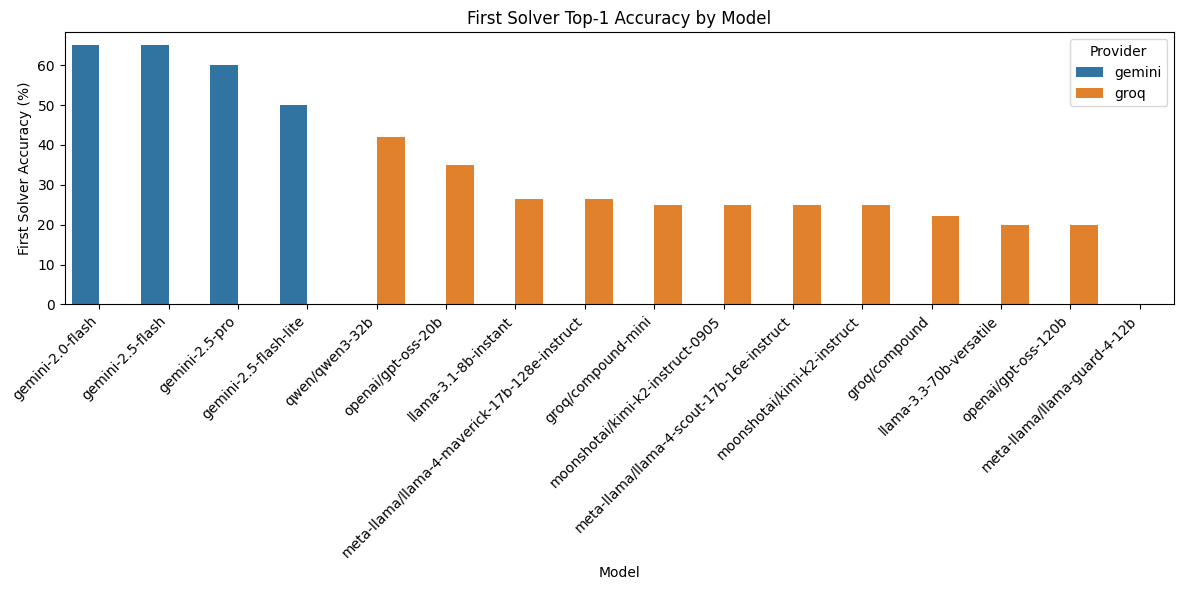

In [10]:
# Plot histogram of first solver accuracy for each model
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by accuracy for better visualization
plot_df = first_solver_accuracy.sort_values('accuracy_percent', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(
    data=plot_df,
    x='model',
    y='accuracy_percent',
    hue='provider',
    dodge=True
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('First Solver Accuracy (%)')
plt.xlabel('Model')
plt.title('First Solver Top-1 Accuracy by Model')
plt.legend(title='Provider')
plt.tight_layout()
plt.show()

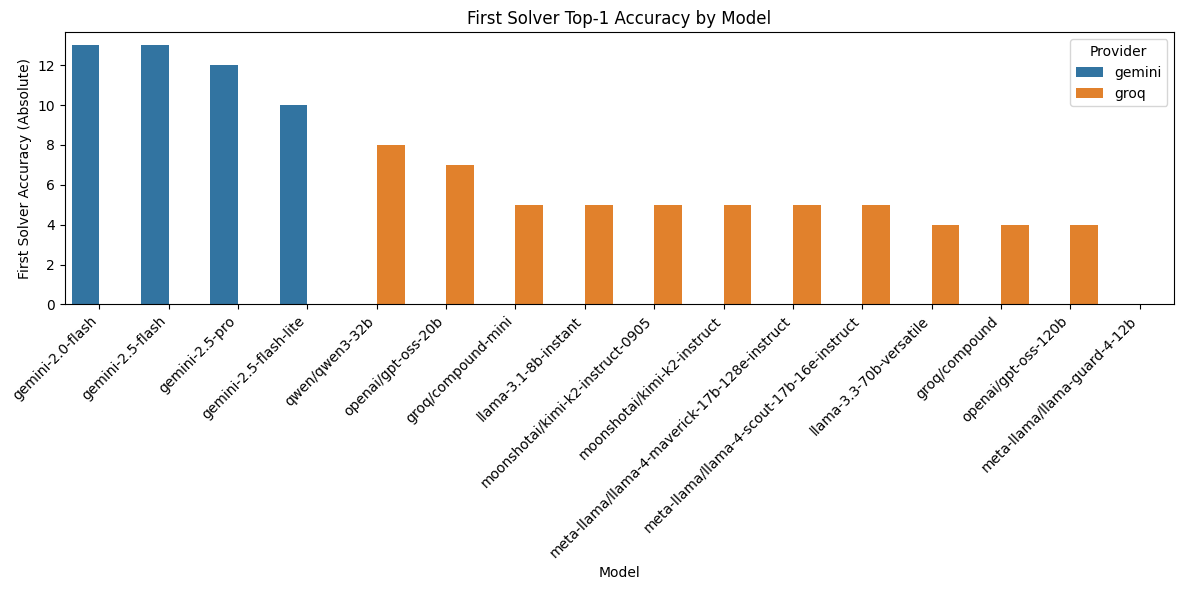

In [12]:
# Sort by accuracy for better visualization
plot_df = first_solver_accuracy.sort_values('num_correct_first_solver', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(
    data=plot_df,
    x='model',
    y='num_correct_first_solver',
    hue='provider',
    dodge=True
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('First Solver Accuracy (Absolute)')
plt.xlabel('Model')
plt.title('First Solver Top-1 Accuracy by Model')
plt.legend(title='Provider')
plt.tight_layout()
plt.show()

### Inverse Evaluation

In [34]:
# For each problem, list which models did NOT guess the top1 solver
# This builds a DataFrame with one row per problem, and a list of (provider, model) that missed the top1

def missed_top1_models(df):
    missed = df[df['correct_first'] == False][['provider', 'model']]
    return list(missed.itertuples(index=False, name=None))

# Use include_group=False to silence the FutureWarning
missed_by_problem = results_with_gt.groupby('problem', group_keys=False).apply(missed_top1_models).reset_index()
missed_by_problem.columns = ['problem', 'missed_models']

# Print problems with at least one missed model
missed_by_problem = missed_by_problem[missed_by_problem['missed_models'].apply(len) > 0]

# Sort by number of missed models
missed_by_problem['num_missed'] = missed_by_problem['missed_models'].apply(len)
missed_by_problem = missed_by_problem.sort_values('num_missed', ascending=False)

# Display the problems with at least one missed model, sorted by number of misses
missed_by_problem[['problem', 'num_missed', 'missed_models']].head(20)

/tmp/ipykernel_9880/3450848208.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missed_by_problem = results_with_gt.groupby('problem', group_keys=False).apply(missed_top1_models).reset_index()


,problem,num_missed,missed_models
3,carpet-cutting,13,"[(gemini, gemini-2.5-flash), (groq, moonshotai..."
2,black-hole,13,"[(gemini, gemini-2.5-flash), (gemini, gemini-2..."
10,ihtc-2024-marte,13,"[(gemini, gemini-2.5-flash-lite), (groq, moons..."
6,groupsplitter,13,"[(gemini, gemini-2.5-flash-lite), (groq, moons..."
18,tsptw,13,"[(gemini, gemini-2.5-pro), (gemini, gemini-2.0..."
13,products-and-shelves,13,"[(gemini, gemini-2.5-flash), (gemini, gemini-2..."
8,hitori,12,"[(gemini, gemini-2.5-flash), (gemini, gemini-2..."
19,work-task-variation,12,"[(gemini, gemini-2.5-flash-lite), (groq, moons..."
0,EchoSched,11,"[(groq, moonshotai/kimi-k2-instruct-0905), (gr..."
1,atsp,11,"[(groq, moonshotai/kimi-k2-instruct-0905), (gr..."


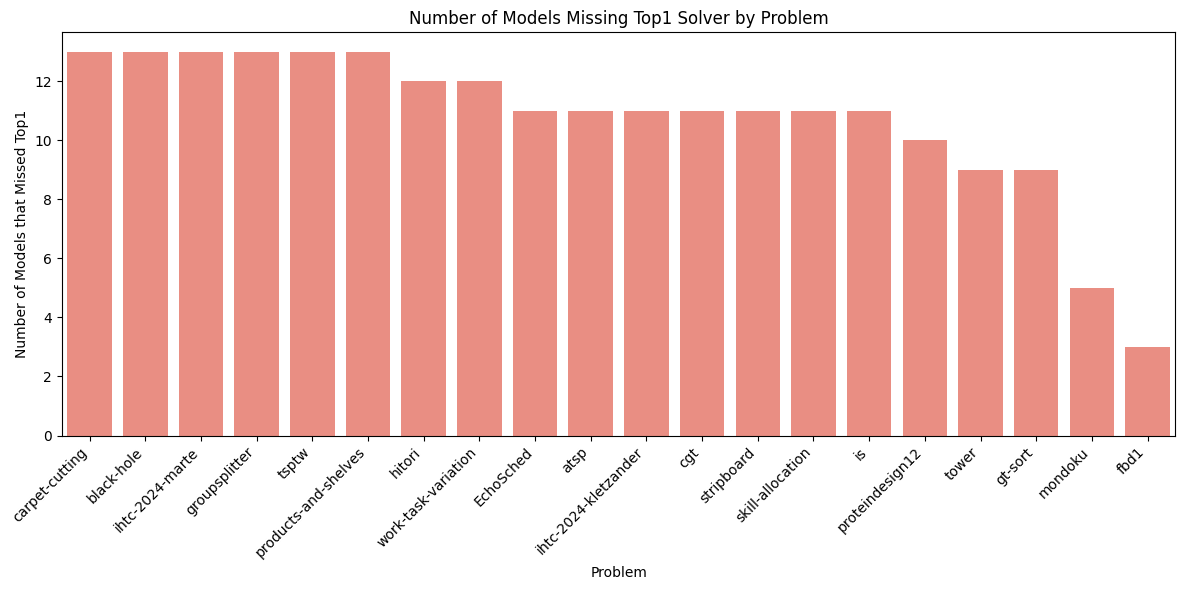

In [29]:
# Plot histogram: for each problem, how many models missed the top1 solver
plt.figure(figsize=(12,6))
missed_by_problem_sorted = missed_by_problem.sort_values('num_missed', ascending=False)
sns.barplot(
    data=missed_by_problem_sorted,
    x='problem',
    y='num_missed',
    color='salmon'
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Models that Missed Top1')
plt.xlabel('Problem')
plt.title('Number of Models Missing Top1 Solver by Problem')
plt.tight_layout()
plt.show()

## Second metric
For each model, we count how many solvers out of the top 3 did it guess in thirds

In [7]:
# For each model/problem, count how many of the guessed solvers are in the ground truth top3_solvers (unordered)
# Give 1/3 point for each correct solver, sum for each model

def count_overlap(guessed, top3):
    if not isinstance(guessed, list) or not isinstance(top3, list):
        return 0.0
    return sum(1 for s in guessed if s in top3) / 3.0

results_with_gt['unordered_score'] = results_with_gt.apply(
    lambda row: count_overlap(row['solvers'], row['top3_solvers']), axis=1
)

# Group by provider/model and sum the scores
unordered_accuracy = results_with_gt.groupby(['provider', 'model'])['unordered_score'].sum().reset_index()
unordered_accuracy = unordered_accuracy.rename(columns={'unordered_score': 'total_unordered_score'})

# Also count total attempted (non-null predictions) for normalization
unordered_attempts = results_with_gt.groupby(['provider', 'model'])['solvers'].count().reset_index()
unordered_attempts = unordered_attempts.rename(columns={'solvers': 'num_attempted'})

# Merge counts
unordered_accuracy = unordered_accuracy.merge(unordered_attempts, on=['provider', 'model'])

# Add average unordered score per problem (max is 1.0)
unordered_accuracy['avg_unordered_score'] = unordered_accuracy['total_unordered_score'] / unordered_accuracy['num_attempted']

unordered_accuracy.sort_values(['provider', 'avg_unordered_score'], ascending=[True, False])

,provider,model,total_unordered_score,num_attempted,avg_unordered_score
0,gemini,gemini-2.0-flash,18.000000,20,0.900000
1,gemini,gemini-2.5-flash,18.000000,20,0.900000
2,gemini,gemini-2.5-flash-lite,18.000000,20,0.900000
3,gemini,gemini-2.5-pro,18.000000,20,0.900000
5,groq,groq/compound-mini,18.000000,20,0.900000
7,groq,llama-3.3-70b-versatile,18.000000,20,0.900000
9,groq,meta-llama/llama-4-scout-17b-16e-instruct,18.000000,20,0.900000
11,groq,moonshotai/kimi-k2-instruct,18.000000,20,0.900000
12,groq,moonshotai/kimi-k2-instruct-0905,18.000000,20,0.900000
13,groq,openai/gpt-oss-120b,18.000000,20,0.900000


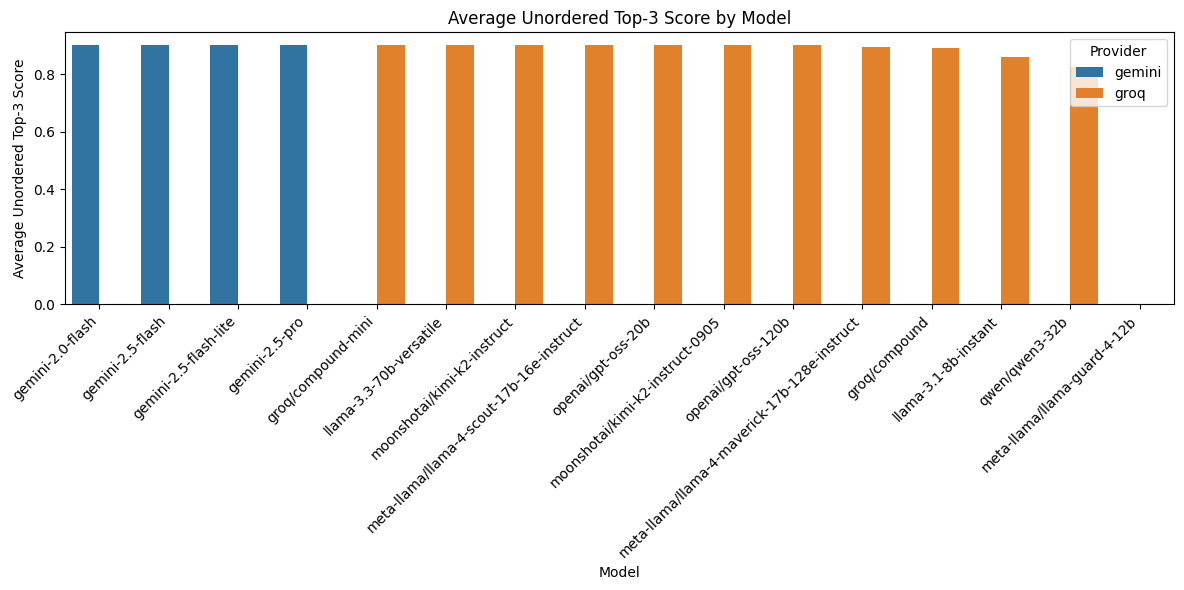

In [8]:
# Plot histogram of average unordered score for each model
plt.figure(figsize=(12,6))
plot_df2 = unordered_accuracy.sort_values('avg_unordered_score', ascending=False)
sns.barplot(
    data=plot_df2,
    x='model',
    y='avg_unordered_score',
    hue='provider',
    dodge=True
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Unordered Top-3 Score')
plt.xlabel('Model')
plt.title('Average Unordered Top-3 Score by Model')
plt.legend(title='Provider')
plt.tight_layout()
plt.show()

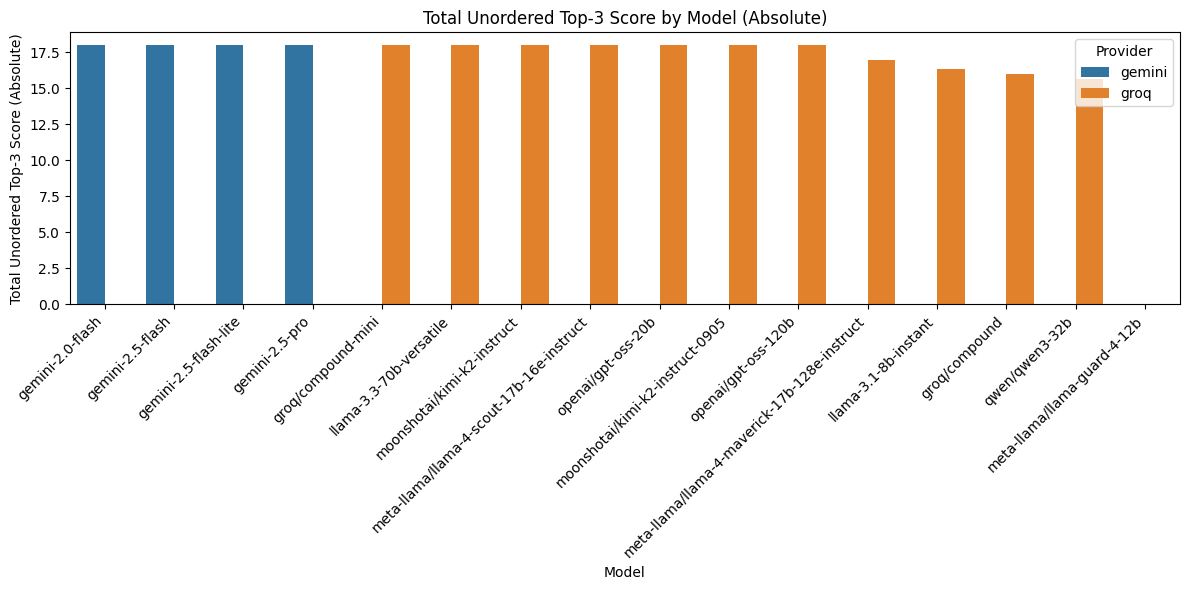

In [9]:
# Plot histogram of total unordered score (absolute number of correct unordered solver guesses) for each model
plt.figure(figsize=(12,6))
plot_df3 = unordered_accuracy.sort_values('total_unordered_score', ascending=False)
sns.barplot(
    data=plot_df3,
    x='model',
    y='total_unordered_score',
    hue='provider',
    dodge=True
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total Unordered Top-3 Score (Absolute)')
plt.xlabel('Model')
plt.title('Total Unordered Top-3 Score by Model (Absolute)')
plt.legend(title='Provider')
plt.tight_layout()
plt.show()